In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

%matplotlib inline

BASE_DIR = Path("..").resolve()
DATA_DIR = BASE_DIR / "data"

BASE_DIR, DATA_DIR


(WindowsPath('E:/work/project/scania_rul_survival'),
 WindowsPath('E:/work/project/scania_rul_survival/data'))

In [3]:
oper = pd.read_csv(DATA_DIR / "train_operational_readouts.csv")
repair = pd.read_csv(DATA_DIR / "train_tte.csv")
spec  = pd.read_csv(DATA_DIR / "train_specifications.csv")

oper.head(), repair.head(), spec.head()


(   vehicle_id  time_step     171_0    666_0       427_0   837_0   167_0  \
 0           0       11.2  167985.0  10787.0   7413813.0  2296.0  4110.0   
 1           0       11.4  167985.0  10787.0   7413813.0  2296.0  4111.0   
 2           0       19.6  331635.0  14525.0  13683604.0  2600.0     NaN   
 3           0       20.2  354975.0  15015.0  14540449.0  2616.0     NaN   
 4           0       21.0  365550.0  15295.0  14966985.0  2720.0     NaN   
 
        167_1      167_2     167_3  ...    397_26   397_27  397_28  397_29  \
 0  1296420.0  1628265.0  630345.0  ...   95728.0  15609.0  1984.0     8.0   
 1  1302855.0  1628265.0  630345.0  ...   95729.0  15610.0  1984.0     8.0   
 2        NaN        NaN       NaN  ...  142900.0  19263.0  2441.0    12.0   
 3        NaN        NaN       NaN  ...  150565.0  19832.0  2522.0    12.0   
 4        NaN        NaN       NaN  ...  155913.0  20573.0  2562.0    12.0   
 
    397_30    397_31    397_32    397_33   397_34  397_35  
 0   784.0  

In [5]:
oper.columns
repair.columns
spec.columns


Index(['vehicle_id', 'Spec_0', 'Spec_1', 'Spec_2', 'Spec_3', 'Spec_4',
       'Spec_5', 'Spec_6', 'Spec_7'],
      dtype='object')

In [6]:
print("operational columns:")
print(oper.columns.tolist(), "\n")

print("tte / repair columns:")
print(repair.columns.tolist())


operational columns:
['vehicle_id', 'time_step', '171_0', '666_0', '427_0', '837_0', '167_0', '167_1', '167_2', '167_3', '167_4', '167_5', '167_6', '167_7', '167_8', '167_9', '309_0', '272_0', '272_1', '272_2', '272_3', '272_4', '272_5', '272_6', '272_7', '272_8', '272_9', '835_0', '370_0', '291_0', '291_1', '291_2', '291_3', '291_4', '291_5', '291_6', '291_7', '291_8', '291_9', '291_10', '158_0', '158_1', '158_2', '158_3', '158_4', '158_5', '158_6', '158_7', '158_8', '158_9', '100_0', '459_0', '459_1', '459_2', '459_3', '459_4', '459_5', '459_6', '459_7', '459_8', '459_9', '459_10', '459_11', '459_12', '459_13', '459_14', '459_15', '459_16', '459_17', '459_18', '459_19', '397_0', '397_1', '397_2', '397_3', '397_4', '397_5', '397_6', '397_7', '397_8', '397_9', '397_10', '397_11', '397_12', '397_13', '397_14', '397_15', '397_16', '397_17', '397_18', '397_19', '397_20', '397_21', '397_22', '397_23', '397_24', '397_25', '397_26', '397_27', '397_28', '397_29', '397_30', '397_31', '397_32',

In [7]:
# 1) merge operational data with time-to-event info
df = oper.merge(
    repair,
    on="vehicle_id",   # ✅ ONLY vehicle_id
    how="left"
)

# 2) merge specifications
df = df.merge(
    spec,
    on="vehicle_id",
    how="left"
)

df.shape, df.columns[:30]


((1122452, 117),
 Index(['vehicle_id', 'time_step', '171_0', '666_0', '427_0', '837_0', '167_0',
        '167_1', '167_2', '167_3', '167_4', '167_5', '167_6', '167_7', '167_8',
        '167_9', '309_0', '272_0', '272_1', '272_2', '272_3', '272_4', '272_5',
        '272_6', '272_7', '272_8', '272_9', '835_0', '370_0', '291_0'],
       dtype='object'))

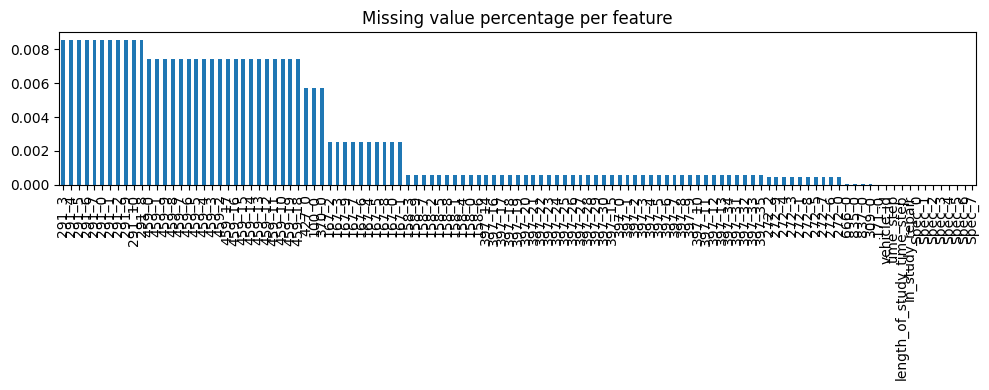

In [8]:
missing_pct = df.isna().mean().sort_values(ascending=False)
missing_pct.head(20)
plt.figure(figsize=(10, 4))
missing_pct.plot(kind="bar")
plt.title("Missing value percentage per feature")
plt.tight_layout()
plt.show()


In [9]:
df = df.sort_values(["vehicle_id", "time_step"])
df = df.bfill()

df.isna().mean().max()


np.float64(0.0)

In [10]:
spec_cols = [c for c in df.columns if c.startswith("Spec_")]
spec_cols[:10], len(spec_cols)
df_encoded = pd.get_dummies(df, columns=spec_cols, drop_first=False)
df_encoded.shape



(1122452, 199)

In [11]:
df_encoded["RUL"] = (
    df_encoded["length_of_study_time_step"]
    - df_encoded["time_step"]
)

df_encoded[["vehicle_id", "time_step", "length_of_study_time_step", "RUL"]].head()


,vehicle_id,time_step,length_of_study_time_step,RUL
0,0,11.2,510.0,498.8
1,0,11.4,510.0,498.6
2,0,19.6,510.0,490.4
3,0,20.2,510.0,489.8
4,0,21.0,510.0,489.0


In [12]:
df_last = (
    df_encoded
    .sort_values(["vehicle_id", "RUL"])
    .groupby("vehicle_id", as_index=False)
    .first()
)

df_last[["vehicle_id", "time_step", "length_of_study_time_step", "RUL"]].head()
print("Number of vehicles:", df_last.shape[0])


Number of vehicles: 23550


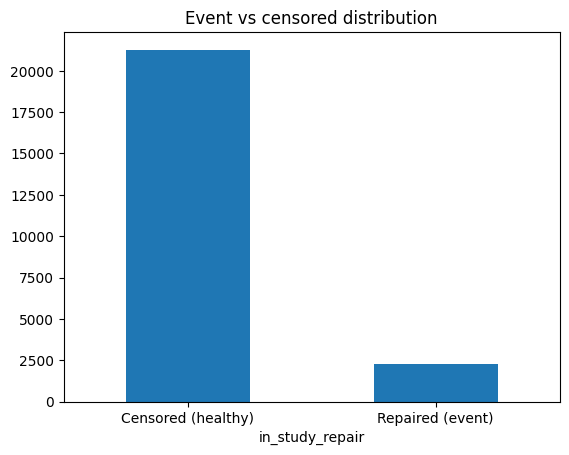

Repaired %: 9.64755838641189
Censored %: 90.35244161358811


In [14]:
event_counts = df_last["in_study_repair"].value_counts()
event_counts

event_counts.plot(kind="bar")
plt.xticks([0, 1], ["Censored (healthy)", "Repaired (event)"], rotation=0)
plt.title("Event vs censored distribution")
plt.show()

print("Repaired %:", 100 * event_counts.get(1, 0) / event_counts.sum())
print("Censored %:", 100 * event_counts.get(0, 0) / event_counts.sum())


In [15]:
drop_non_features = [
    "vehicle_id",
    "time_step",
    "length_of_study_time_step",
    "in_study_repair",
    "RUL"
]

feature_cols = [c for c in df_last.columns if c not in drop_non_features]

X_raw = df_last[feature_cols]
y_rul = df_last["RUL"]

X_raw.shape


(23550, 195)

In [16]:
corr_with_rul = X_raw.corrwith(y_rul)

low_corr_features = corr_with_rul[abs(corr_with_rul) < 0.01].index.tolist()
len(low_corr_features), low_corr_features[:20]
X_corr = X_raw.drop(columns=low_corr_features)
X_corr.shape


(23550, 102)

In [17]:
corr_matrix = X_corr.corr().abs()

upper = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)

to_drop = [column for column in upper.columns if any(upper[column] >= 0.90)]

len(to_drop), to_drop[:20]
X_final = X_corr.drop(columns=to_drop)
X_final.shape



(23550, 76)

In [18]:
processed = X_final.copy()
processed["RUL"] = df_last["RUL"].values
processed["in_study_repair"] = df_last["in_study_repair"].values
processed["vehicle_id"] = df_last["vehicle_id"].values

processed_path = DATA_DIR / "scania_processed.parquet"
processed.to_parquet(processed_path, index=False)

processed.head(), processed.shape


(        171_0     666_0     837_0    167_0      167_1       167_2       167_3  \
 0  10189950.0  372685.0   41670.0      0.0   811605.0   1644061.0    560460.0   
 1   5648790.0  289371.0   68717.0  10415.0  9137870.0  74655621.0  45991626.0   
 2   7603590.0  230831.0  100121.0   5918.0  8225139.0  17004223.0  10504195.0   
 3   4842780.0  210381.0  152385.0   7128.0  4342398.0  13348382.0  11538870.0   
 4   6623040.0  280531.0  164673.0      0.0   513466.0    693990.0    350295.0   
 
         167_4       167_6      167_7  ...  Spec_7_Cat0  Spec_7_Cat1  \
 0    873435.0         0.0        0.0  ...         True        False   
 1  65888583.0   5813857.0     3351.0  ...        False         True   
 2  30792854.0  27370868.0  3819383.0  ...        False         True   
 3  30085352.0  53625651.0  1225967.0  ...        False         True   
 4    735390.0       570.0        0.0  ...        False         True   
 
    Spec_7_Cat2  Spec_7_Cat4  Spec_7_Cat5  Spec_7_Cat6  Spec_7_Cat7  RUL